## Домашнее задание

1. Обучите CNN (самописная) на CIFAR-100.
2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
3. *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.
4. Сравните результаты обучения на эквивалентном числе эпох.

### CNN на CIFAR-100

In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

from torch import nn
from torch import optim
from tqdm import tqdm

import matplotlib.pyplot as plt
# %pylab inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
dataset = datasets.CIFAR100(root='data/',train=True, download=True)

Files already downloaded and verified


In [4]:
dataset

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data/
    Split: Train

In [5]:
classes = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus',
         'butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couchq',
         'crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house',
         'kangaroo','keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain',
         'mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate',
         'poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk',
         'skyscraper','snail','snake','spider','squirrel', 'streetcar','sunflower','sweet_pepper','table','tank','telephone',
         'television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm']

In [6]:
len(classes)

100

In [7]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

def train_valid_split(i):
    X_train, X_test = train_test_split(i, test_size=0.1, random_state=10)
    return X_train, X_test

class MyOwnCifar(torch.utils.data.Dataset):

    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]



Files already downloaded and verified


In [8]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor()])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 224, 224])
clock


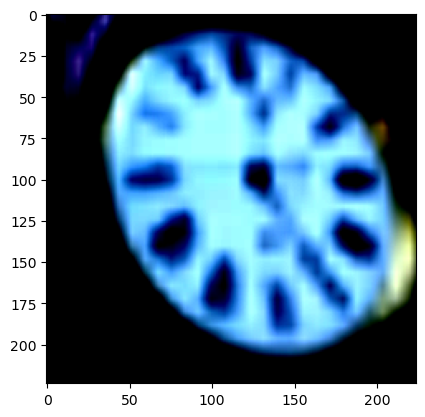

In [32]:
import matplotlib.pyplot as plt


for img, lbl in train_loader:
    print(img.shape)
    print(classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [10]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)

        self.bn_one = torch.nn.BatchNorm2d(3)
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30)
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 250)
        self.fc2 = torch.nn.Linear(250, 150)
        self.out = torch.nn.Linear(150, 100)


    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)

net = Net()
print(net)

Net(
  (dp_three): Dropout(p=0.2, inplace=False)
  (dp_four): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=150, bias=True)
  (out): Linear(in_features=150, out_features=100, bias=True)
)


In [11]:
# !pip install torchsummary

In [12]:
from torchsummary import summary

summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 15, 15]              60
            Conv2d-4           [-1, 60, 13, 13]          16,260
       BatchNorm2d-5             [-1, 60, 6, 6]             120
            Conv2d-6            [-1, 120, 4, 4]          64,920
       BatchNorm2d-7            [-1, 120, 2, 2]             240
           Dropout-8                  [-1, 480]               0
            Linear-9                  [-1, 250]         120,250
          Dropout-10                  [-1, 250]               0
           Linear-11                  [-1, 150]          37,650
           Linear-12                  [-1, 100]          15,100
Total params: 255,446
Trainable params: 255,446
Non-trainable params: 0
-------------------------------

In [13]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

In [14]:
num_epochs = 5
net.train()

for epoch in range(num_epochs):
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()

        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()

            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):

                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        net.train()

print('Training is finished!')

Epoch [1/5]. Step [1/352]. Loss: 0.036. Acc: 0.008. Test acc: 0.008
Epoch [1/5]. Step [301/352]. Loss: 0.031. Acc: 0.088. Test acc: 0.104
Epoch [2/5]. Step [1/352]. Loss: 0.028. Acc: 0.133. Test acc: 0.116
Epoch [2/5]. Step [301/352]. Loss: 0.028. Acc: 0.149. Test acc: 0.131
Epoch [3/5]. Step [1/352]. Loss: 0.027. Acc: 0.188. Test acc: 0.133
Epoch [3/5]. Step [301/352]. Loss: 0.026. Acc: 0.182. Test acc: 0.178
Epoch [4/5]. Step [1/352]. Loss: 0.026. Acc: 0.172. Test acc: 0.160
Epoch [4/5]. Step [301/352]. Loss: 0.025. Acc: 0.204. Test acc: 0.170
Epoch [5/5]. Step [1/352]. Loss: 0.026. Acc: 0.188. Test acc: 0.168
Epoch [5/5]. Step [301/352]. Loss: 0.025. Acc: 0.223. Test acc: 0.182
Training is finished!


### CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

In [15]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
print(resnet50)

C:\Users\Relict\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Relict\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
from torchsummary import summary
summary(resnet50.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Замораживаем претренированную модель:

In [18]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

Можем заменить свой слой для работы на выходе(у нас их 10):

In [20]:
resnet50.fc = nn.Linear(2048, 100)
summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

Перемещем модель и данные на целевой устройство:

In [21]:
resnet50 = resnet50.to(device)

Данные:

In [22]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

In [23]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=0)

Нужно собрать список параметров для адаптации

In [24]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

Учим:

In [25]:
num_epochs = 5
resnet50.train()

for epoch in range(num_epochs):
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()

        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet50.eval()

            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):

                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet50.train()

print('Training is finished!')

Epoch [1/5]. Step [1/352]. Loss: 0.036. Acc: 0.008. Test acc: 0.015
Epoch [1/5]. Step [301/352]. Loss: 0.020. Acc: 0.395. Test acc: 0.532
Epoch [2/5]. Step [1/352]. Loss: 0.014. Acc: 0.531. Test acc: 0.522
Epoch [2/5]. Step [301/352]. Loss: 0.014. Acc: 0.536. Test acc: 0.556
Epoch [3/5]. Step [1/352]. Loss: 0.014. Acc: 0.492. Test acc: 0.567
Epoch [3/5]. Step [301/352]. Loss: 0.013. Acc: 0.563. Test acc: 0.567
Epoch [4/5]. Step [1/352]. Loss: 0.012. Acc: 0.609. Test acc: 0.573
Epoch [4/5]. Step [301/352]. Loss: 0.012. Acc: 0.578. Test acc: 0.574
Epoch [5/5]. Step [1/352]. Loss: 0.014. Acc: 0.516. Test acc: 0.573
Epoch [5/5]. Step [301/352]. Loss: 0.012. Acc: 0.587. Test acc: 0.581
Training is finished!


In [26]:
resnet50.eval()
for data in valid_loader:
  test_outputs = resnet50(data[0].to(device))
  label = data[1].to(device)
  predict = torch.max(test_outputs, 1)[1]
  break
print(predict)
print(label)
print((predict == label).sum()/predict.shape[0])

tensor([46,  2, 96, 44,  8, 19, 24, 68,  7, 48, 97,  4, 99, 23, 21, 36,  4,  3,
         1, 28, 31, 28,  1, 65, 74, 57, 65,  7, 11, 96, 71, 42, 17,  4, 16, 18,
         6, 37, 16, 95, 76, 77, 79, 62, 92, 65, 54, 38,  8, 22, 32, 54, 43,  0,
        86, 61,  6, 21, 86, 97,  6,  9, 42, 61, 48, 72, 27, 93, 16, 94, 91, 79,
        63, 42, 95, 86, 89, 58,  6, 74, 79, 56, 49, 16, 49,  3, 43, 21, 53, 75,
         6, 86, 47, 21, 62, 64, 79, 41, 90, 58, 61, 15,  5, 77, 44,  2, 18, 83,
        39, 51, 64, 48, 27, 20, 27, 93, 54,  1, 68, 94, 97, 42, 94, 22, 37, 14,
         7, 88], device='cuda:0')
tensor([46,  2, 52, 69,  8, 19, 24, 68, 74,  2, 50,  4, 99, 23, 21, 36, 72,  3,
         1, 10, 31, 28,  1, 72, 14, 57, 65,  7,  2, 96, 71, 80, 60, 55, 16, 18,
        32, 37,  9, 30, 76, 55, 79, 62, 62, 38, 54, 38, 15, 10, 91, 92, 36,  0,
        25, 61, 74, 31, 39, 97,  6,  9,  4, 61, 66, 72, 27, 27, 10, 94,  1, 79,
        63, 65, 95, 86, 58, 58, 93, 74, 34, 56, 23, 16, 60,  3, 43, 21, 53, 75,
      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


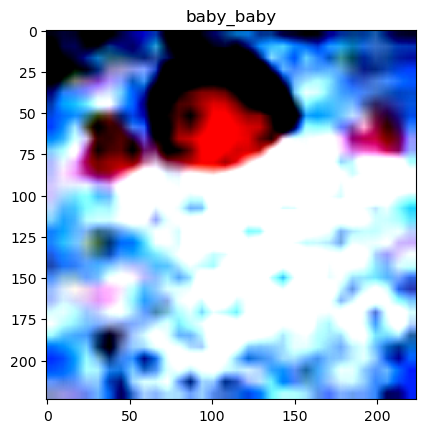

In [31]:
N = 1
plt.imshow(data[0][N,:,:,:].permute(1, 2, 0))
plt.title(classes[label[N]]+'_'+classes[predict[N]])
plt.show()

### Вывод: Самописная нейронная сеть по итогу 5 эпох на датасете CIFAR-100 показала тестовую точность Test acс=0.182, что указывает на "недостаточную мощность" сети и малый объем обучающих данных. Нейронная сеть с дообученим ImageNet Resnet-50 при прочих равных условиях показала тестовую точность Test acс=0.581, что показывает превосходство модели над самописной в более чем 3 раза, но еще раз показывает на недостаточность обучающих данных.Вариант повышения тестовой точности моделей - аугментация данных модулем transforms (например: методы RandomCrop, RandomHorizontalFlip)